In [5]:
import time

import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
from scipy.signal import fftconvolve

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_prepocessing import ArticlesDataset

In [6]:
data = fetch_20newsgroups(data_home='./data/', subset='all').data
df = pd.DataFrame(data, columns=['text'])
df

,text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...
...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...
18843,From: westes@netcom.com (Will Estes)\nSubject:...
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...


In [61]:
df = pd.read_csv('./data/bbc_text_cls.csv')
maxlen = np.quantile(df.text.apply(len), q=0.99)
print(len(df))
df = df[df.text.apply(len) < maxlen].reset_index(drop=True)
df

2225


,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business
...,...,...
2197,TV's future down the phone line\n\nInternet TV...,tech
2198,Cebit fever takes over Hanover\n\nThousands of...,tech
2199,BT program to beat dialler scams\n\nBT is intr...,tech
2200,Spam e-mails tempt net shoppers\n\nComputer us...,tech


In [12]:
def create_context_coeff_matrix(ctx_len, seq_len):
    gamma = 1 / ctx_len

    # construct tril matrix (suffix context)
    tril_matrix = np.zeros((seq_len, seq_len))
    for i in np.arange(1, ctx_len + 1):
        tril_matrix[np.arange(i, seq_len), np.arange(seq_len - i)] = gamma * (1 - gamma) ** i

    # contstruct full matrix (self + prefix + suffix context)
    full_matrix = tril_matrix + tril_matrix.T + np.eye(tril_matrix.shape[0]) * gamma

    # normalize weights and transpose
    full_matrix /= full_matrix.sum(axis=0)
    full_matrix = full_matrix.T
    return jnp.array(full_matrix)

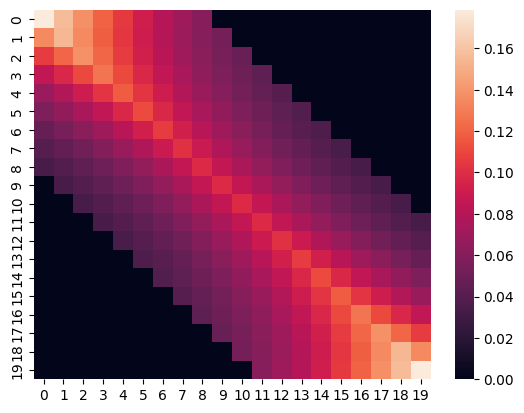

In [13]:
cf = create_context_coeff_matrix(ctx_len=8, seq_len=20)
sns.heatmap(cf)
plt.show()

In [14]:
a = np.array([[2, 3], [4, 5]])

b = np.array([0, 0, 1, 0])

np.take_along_axis(a, b[:, None], axis=0)

array([[2, 3],
       [2, 3],
       [4, 5],
       [2, 3]])

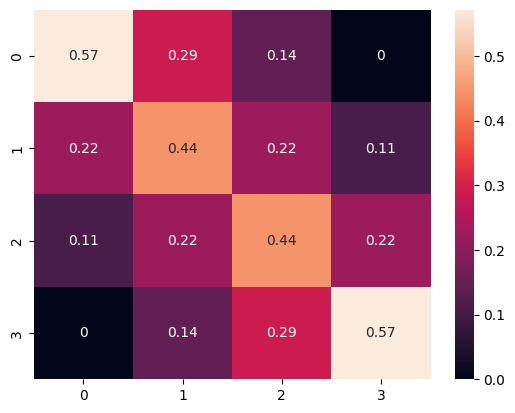

In [15]:
cf = create_context_coeff_matrix(ctx_len=2, seq_len=4)
sns.heatmap(cf, annot=True)
plt.show()

In [9]:
np.array([[1, 1], [2, 2], [3, 3], [4, 4]])[None, ...]

array([[[1, 1],
        [2, 2],
        [3, 3],
        [4, 4]]])

In [10]:
tensor = jnp.array([
    [[1, 1], [2, 2], [3, 3], [4, 4]],
    # 0.57 * [1, 1] + 0.29 * [2, 2] + 0.14 * [3, 3] + 0    * [4, 4] = [1.57, 1.57]
    # 0.22 * [1, 1] + 0.44 * [2, 2] + 0.22 * [3, 3] + 0.11 * [4, 4] = [2.2, 2.2]
    # 0.11 * [1, 1] + 0.22 * [2, 2] + 0.44 * [3, 3] + 0.22 * [4, 4] = [2.75, 2.75]
    # 0    * [1, 1] + 0.14 * [2, 2] + 0.29 * [3, 3] + 0.57 * [4, 4] = [3.43, 3.43]
    [[1, 2], [3, 4], [5, 6], [8, 9]],
])  # (D, W, T)
# (W, W)

# res = np.einsum('hwk,wj->hwk', tensor, cf)
# res = np.dot(tensor, cf[None, ...])
# res = fftconvolve(tensor[:, None, :, :], cf[::-1][None, :, :, None], mode='valid', axes=2)
res = jnp.sum(tensor[:, None, :, :] * cf[None, :, :, None], axis=2)
# res = res.sum(axis=2)
res.shape, res

((2, 4, 2),
 Array([[[1.5714287, 1.5714287],
         [2.2222223, 2.2222223],
         [2.777778 , 2.777778 ],
         [3.4285717, 3.4285717]],
 
        [[2.142857 , 3.1428573],
         [3.5555556, 4.555556 ],
         [4.7777777, 5.777778 ],
         [6.4285717, 7.428572 ]]], dtype=float32))

In [11]:
res.reshape(-1, res.shape[-1])

Array([[1.5714287, 1.5714287],
       [2.2222223, 2.2222223],
       [2.777778 , 2.777778 ],
       [3.4285717, 3.4285717],
       [2.142857 , 3.1428573],
       [3.5555556, 4.555556 ],
       [4.7777777, 5.777778 ],
       [6.4285717, 7.428572 ]], dtype=float32)

In [12]:
key = jax.random.key(42)
tensor = jax.random.normal(
    key=key,
    shape=(2000, 500, 10),
)  # (D, W, T)
cf = create_context_coeff_matrix(ctx_len=5, seq_len=500)
print(tensor.shape, cf.shape)

def foo(x, y):
    return jnp.sum(x[:, None, :, :] * y[None, :, :, None], axis=2)

print('Testing base function:')
%timeit foo(tensor, cf)
# print('Testing vectorized function:')
# vf = jax.vmap(foo)
# %timeit vf(tensor[:, None, :, :], cf[None, :, :, None])
print('Testing jit-compilation on base function:')
jf = jax.jit(foo)
%timeit jf(tensor, cf)
# print('Testing jit-compilation on vectorized function:')
# jvf = jax.jit(vf)
# %timeit jvf(tensor, cf)
print('Testing inline function:')
%timeit jnp.sum(tensor[:, None, :, :] * cf[None, :, :, None], axis=2)

(2000, 500, 10) (500, 500)
Testing base function:
2.81 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Testing jit-compilation on base function:
The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached.
2.31 s ± 1 s per loop (mean ± std. dev. of 7 runs, 10 loops each)
Testing inline function:
11.9 s ± 321 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
@jax.jit
def _norm(x: jax.Array):
    # take x+ = max(x, 0) element-wise (perform projection on positive simplex)
    x = jnp.maximum(x, jnp.zeros_like(x))
    # normalize values in non-zero rows to 1 (mapping from the positive simplex to the unit simplex)
    norm = x.sum(axis=0)
    x = jnp.where(norm > 1e-12, x / norm, jnp.zeros_like(x))
    return x

_norm(
    jnp.array([
        [1, -1, 1, 2],
        [1, 3, -4, 3],
    ])
)

Array([[0.5, 0. , 1. , 0.4],
       [0.5, 1. , 0. , 0.6]], dtype=float32)

In [16]:
indices = np.array([0, 0, 0, 1, 2, 1, 3, 2])
values = np.array([[0.1, 0.3], [2, 4], [5, 2], [1, 0]])

# Create a one-hot encoding of the indices
one_hot_indices = np.eye(indices.max() + 1)[indices]

# Multiply the one-hot encoding by the values
multiplied_values = values * one_hot_indices.sum(axis=0)[:, None]

print(multiplied_values)  # Output: [0.2, 4, 0.1, 10]

[[ 0.3  0.9]
 [ 4.   8. ]
 [10.   4. ]
 [ 1.   0. ]]


In [7]:
class ContextTopicModelDebug():
    """
    Topic model which uses local context of words
    """

    def __init__(
            self,
            ctx_len: int,
            max_len: int,
            vocab_size: int,
            n_topics: int = 10,
            reg_list: list = None,
            eps: float = 1e-12,
    ):
        """
        Args:
            ctx_len: one-sided context size
            max_len: max length of a document, W_d
            vocab_size: corpus vocabulary size, W
            n_topics: number of topics, T
            regularizations: list of regularizations (see `add_regularization` method)
            eps: parameter set for balance between numerical stability and precision

        Note:
            - Total context of a word on `i`-th index is ctx_len words to the left,\\
            `ctx_len` words to the right, and the word itself
            - All documents should be padded to `max_len` length
        """
        self.ctx_len = ctx_len
        self.seq_len = max_len
        self.n_topics = n_topics
        self.vocab_size = vocab_size
        self._eps = eps

        self._context_coeffs = self._create_context_coeff_matrix()

        self._regularizations = dict()
        if reg_list is not None:
            for reg in reg_list:
                self.add_regularization(reg)

    def _norm(self, x: jax.Array) -> jax.Array:
        assert jnp.any(~jnp.isnan(x)), jnp.sum(x)
        # take x+ = max(x, 0) element-wise (perform projection on positive simplex)
        x = jnp.maximum(x, jnp.zeros_like(x))
        # normalize values in non-zero rows to 1 (mapping from the positive simplex to the unit simplex)
        norm = x.sum(axis=0)
        x = jnp.where(norm > self._eps, x / norm, jnp.zeros_like(x))
        return x

    def _create_context_coeff_matrix(self) -> jax.Array:
        gamma = 1 / self.ctx_len

        # construct tril matrix (suffix context)
        tril_matrix = np.zeros((self.seq_len, self.seq_len))
        for i in np.arange(1, self.ctx_len + 1):
            tril_matrix[np.arange(i, self.seq_len), np.arange(self.seq_len - i)] = gamma * (1 - gamma) ** i

        # contstruct full matrix (self + prefix + suffix context)
        full_matrix = tril_matrix + tril_matrix.T # + np.eye(tril_matrix.shape[0]) * gamma 

        # normalize weights and transpose
        full_matrix /= full_matrix.sum(axis=0)
        full_matrix = full_matrix.T
        return jnp.array(full_matrix)

    def add_regularization(self, reg, tag: str = None):
        """
        Add `reg` regularization to the model with `tag` identifier \\
        Note:
        - `reg` has to be a child of base `Regularization` class
        - `tag` will use the name of the class by default
        """
        if tag is None:
            tag = reg.__name__
        if not isinstance(reg, Regularization):
            raise TypeError(f'Regularization [{tag}] has to be a subclass of Regularization class')

        try:
            self._regularizations[tag] = jax.grad(reg)
        except Exception:
            raise

    def _compose_regularizations(self):
        regs = self._regularizations.values()
        sum_reg = lambda x: sum([1.0, ] + [reg(x) for reg in regs])
        return jax.jit(jax.grad(sum_reg))

    def fit(self, data: jax.Array, max_iter: int = 1000, tol: float = 1e-3, seed: int = 0, test_data=None):
        """
        Args:
            data: matrix of shape (D, W_d), containing tokenized words of each document
            max_iter: max number of iterations
            tol: early stopping threshold
            seed: random seed
        """
        key = jax.random.key(seed)
        self.phi = jax.random.uniform(
            key=key,
            shape=(self.vocab_size, self.n_topics),
        )  # (W, T)
        self.n_t = jnp.full(
            shape=(self.n_topics, ),
            fill_value=jnp.sum(data, dtype=jnp.float32) / self.n_topics,
        )  # (T, )
        grad_regularization = self._compose_regularizations()

        self.phi = self._norm(self.phi)
        t_cur = time.time()
        for it in range(max_iter):
            # Calculate phi' (words -> topics) matrix (phi with old p_{ti})
            print(np.array(self.phi).shape, np.array(self.n_t).shape, f'{time.time() - t_cur:.01f}')
            phi_hatch = self._norm(self.phi.T * self.n_t[:, None]).T  # (W, T)
            print(np.array(phi_hatch).shape, f'{time.time() - t_cur:.01f}')

            # Create theta (documents -> topics) matrix
            # We can interpret phi as a bunch of embeddings for words,
            # thus creating tensor of embeddings of words in documents
            # and calculating context (document embedding), based on this
            data_emb = jnp.take_along_axis(phi_hatch[None, ...], indices=data[..., None], axis=1)  # (D, W_d, T)
            print(np.array(data_emb)[:, None, :, :].shape, self._context_coeffs[::-1][None, :, :, None].shape, f'{time.time() - t_cur:.01f}')
            theta_new = jnp.sum(
                data_emb[:, None, :, :] * self._context_coeffs[None, :, :, None],
                axis=2,
            )  # (D, W_d, T)
            print(np.array(theta_new).shape, f'{time.time() - t_cur:.01f}')
            # Now we see each context window as a new document, I - number of context documents
            theta_new = theta_new.reshape(-1, theta_new.shape[-1])  # (I, T)

            # Update p_{ti} - topic probability distribution for i-th context
            data_emb = jnp.take_along_axis(self.phi[None, ...], indices=data[..., None], axis=1)  # (D, W_d, T)
            print(np.array(data_emb).shape, f'{time.time() - t_cur:.01f}')
            p_ti = data_emb.reshape(-1, data_emb.shape[-1])  # (I, T)
            p_ti = self._norm((p_ti * theta_new).T).T  # (I, T)
            print(np.array(p_ti).shape, f'{time.time() - t_cur:.01f}')

            # Update n_{t} - topic probability distribution
            self.n_t = jnp.sum(p_ti, axis=0)  # (T, )
            print(np.array(self.n_t).shape, f'{time.time() - t_cur:.01f}')

            # Update phi (words -> topics) matrix (phi with new p_{ti})
            indices = data.flatten()  # (I, )
            phi_new = jnp.add.at(jnp.zeros_like(self.phi), indices, p_ti, inplace=False)  # (W, T)
            print(np.array(phi_new).shape, f'{time.time() - t_cur:.01f}')
            phi_new += self.phi * grad_regularization(self.phi)  # (W, T)
            print(np.array(phi_new).shape, f'{time.time() - t_cur:.01f}')
            phi_new = self._norm(phi_new)  # (W, T)

            diff_norm = jnp.linalg.norm(phi_new - self.phi)
            theta_doc = theta_new.reshape(data.shape + (-1, )).sum(axis=1)
            res_diff_norm = jnp.exp(-jnp.sum(test_data * jnp.log(theta_doc @ phi_new.T + self._eps)) / (data.shape[0] * data.shape[1]))
            print(f'Iteration [{it}/{max_iter}], update diff norm: {diff_norm:.04f}, perplexity: {res_diff_norm:.04f}')
            self.phi = phi_new
            if diff_norm < tol:
                break

In [8]:
maxlen = 100
dataset = ArticlesDataset(df.text.tolist(), maxlen=maxlen)
len(dataset)

18846

In [9]:
bow = CountVectorizer(
    preprocessor=lambda x: ' '.join(ArticlesDataset.preprocess_text(x)),
    tokenizer=word_tokenize,
    vocabulary=dataset.vocab,
).fit_transform(df.text.to_list())
bow = jnp.array(bow.todense())
# bow /= bow.sum(axis=1)[:, None]
bow.shape

/Users/diyakovilya/Library/Caches/pypoetry/virtualenvs/topic-modelling-attention-srLx0cG6-py3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/diyakovilya/Library/Caches/pypoetry/virtualenvs/topic-modelling-attention-srLx0cG6-py3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


(18846, 107673)

In [125]:
%%time

model = ContextTopicModel(
    ctx_len=10,
    max_len=maxlen,
    vocab_size=len(dataset.vocab),
    n_topics=10,
)
model.fit(dataset.data, test_data=bow)

(107673, 10) (10,) 0.0
(107673, 10) 0.0
(18846, 1, 100, 10) (1, 100, 100, 1) 0.0
(18846, 100, 10) 0.7
(18846, 100, 10) 0.7
(1884600, 10) 0.8
(10,) 0.8
(107673, 10) 0.8
(107673, 10) 0.9
Iteration [0/1000], update diff norm: 0.5189, perplexity: 5962.7715
(107673, 10) (10,) 4.7
(107673, 10) 4.7
(18846, 1, 100, 10) (1, 100, 100, 1) 4.7
(18846, 100, 10) 5.4
(18846, 100, 10) 5.4
(1884600, 10) 5.5
(10,) 5.5
(107673, 10) 5.6
(107673, 10) 5.6
Iteration [1/1000], update diff norm: 0.1516, perplexity: 5956.8662
(107673, 10) (10,) 9.8
(107673, 10) 9.8
(18846, 1, 100, 10) (1, 100, 100, 1) 9.8
(18846, 100, 10) 10.5
(18846, 100, 10) 10.6
(1884600, 10) 10.6
(10,) 10.6
(107673, 10) 10.7
(107673, 10) 10.7
Iteration [2/1000], update diff norm: 0.1706, perplexity: 5861.3770
(107673, 10) (10,) 16.1
(107673, 10) 16.1
(18846, 1, 100, 10) (1, 100, 100, 1) 16.1
(18846, 100, 10) 16.8
(18846, 100, 10) 16.8
(1884600, 10) 16.9
(10,) 16.9
(107673, 10) 17.0
(107673, 10) 17.0
Iteration [3/1000], update diff norm: 0.1

In [126]:
%%time

model = ContextTopicModelDebug(
    ctx_len=100,
    max_len=maxlen,
    vocab_size=len(dataset.vocab),
    n_topics=10,
)
model.fit(dataset.data, test_data=bow)

(107673, 10) (10,) 0.0
(107673, 10) 0.0
(18846, 1, 100, 10) (1, 100, 100, 1) 0.0
(18846, 100, 10) 0.7
(18846, 100, 10) 0.7
(1884600, 10) 0.8
(10,) 0.8
(107673, 10) 0.9
(107673, 10) 0.9
Iteration [0/1000], update diff norm: 0.4974, perplexity: 5963.5566
(107673, 10) (10,) 6.0
(107673, 10) 6.0
(18846, 1, 100, 10) (1, 100, 100, 1) 6.0
(18846, 100, 10) 6.8
(18846, 100, 10) 6.8
(1884600, 10) 6.9
(10,) 6.9
(107673, 10) 6.9
(107673, 10) 7.0
Iteration [1/1000], update diff norm: 0.0717, perplexity: 5955.3384
(107673, 10) (10,) 11.1
(107673, 10) 11.1
(18846, 1, 100, 10) (1, 100, 100, 1) 11.1
(18846, 100, 10) 11.8
(18846, 100, 10) 11.8
(1884600, 10) 11.9
(10,) 11.9
(107673, 10) 12.0
(107673, 10) 12.0
Iteration [2/1000], update diff norm: 0.0862, perplexity: 5840.1572
(107673, 10) (10,) 16.5
(107673, 10) 16.6
(18846, 1, 100, 10) (1, 100, 100, 1) 16.6
(18846, 100, 10) 17.2
(18846, 100, 10) 17.3
(1884600, 10) 17.3
(10,) 17.3
(107673, 10) 17.4
(107673, 10) 17.4
Iteration [3/1000], update diff norm: 

In [127]:
%%time

model = ContextTopicModelDebug(
    ctx_len=500,
    max_len=maxlen,
    vocab_size=len(dataset.vocab),
    n_topics=10,
)
model.fit(dataset.data, test_data=bow)

(107673, 10) (10,) 0.0
(107673, 10) 0.0
(18846, 1, 100, 10) (1, 100, 100, 1) 0.0
(18846, 100, 10) 0.7
(18846, 100, 10) 0.7
(1884600, 10) 0.7
(10,) 0.7
(107673, 10) 0.8
(107673, 10) 0.9
Iteration [0/1000], update diff norm: 0.4942, perplexity: 5963.4033
(107673, 10) (10,) 7.6
(107673, 10) 7.6
(18846, 1, 100, 10) (1, 100, 100, 1) 7.7
(18846, 100, 10) 8.3
(18846, 100, 10) 8.3
(1884600, 10) 8.4
(10,) 8.4
(107673, 10) 8.5
(107673, 10) 8.5
Iteration [1/1000], update diff norm: 0.0599, perplexity: 5956.3892
(107673, 10) (10,) 14.9
(107673, 10) 14.9
(18846, 1, 100, 10) (1, 100, 100, 1) 15.0
(18846, 100, 10) 15.6
(18846, 100, 10) 15.6
(1884600, 10) 15.7
(10,) 15.7
(107673, 10) 15.8
(107673, 10) 15.8
Iteration [2/1000], update diff norm: 0.0722, perplexity: 5844.9102
(107673, 10) (10,) 19.5
(107673, 10) 19.5
(18846, 1, 100, 10) (1, 100, 100, 1) 19.5
(18846, 100, 10) 20.3
(18846, 100, 10) 20.3
(1884600, 10) 20.4
(10,) 20.4
(107673, 10) 20.5
(107673, 10) 20.5
Iteration [3/1000], update diff norm: 

In [107]:
# maxlen = 500, context = 10
topk = jnp.argsort(model.phi, axis=0, descending=True)[:10, :].T  # (T, W_{top})
reverse_vocab = {value: key for key, value in dataset.vocab.items()}

for t in topk:
    print('\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

year	gun	law	government	u	bike	state	israeli	new	american

window	x	use	system	problem	get	need	anyone	drive	file

edu	writes	c	article	subject	apr	cc	news	andrew	uiuc

line	organization	subject	posting	host	nntp	university	distribution	ca	x

one	would	people	think	know	like	time	say	thing	get

thanks	e	please	mail	email	help	advance	p	u	address

com	writes	subject	article	apr	org	gov	netcom	nasa	access

PAD	ryerson	ryevm	keith	sola	employer	acps	tmi	teddy	polytechnical

game	team	player	year	win	last	v	co	play	pitt

PAD	rainer	elin	hochreiter	eeam	keith	excepted	omission	bye	donoghue

